## World Development Indicators - Analytics

In [1]:
import pandas as pd
import numpy as np
import time

datos = pd.read_csv("suramerica.csv").drop('Unnamed: 0', 1)
paises = datos['CountryCode'].drop_duplicates().values.tolist()

preprocessing = 'imput'
search = 'original'
year_init = 2012
year_range = 5
look_back = 3
years = range(year_init-year_range+1,year_init+1)[::-1]

agricultura     = open("Indicadores/iagricultura.txt").read().split(',')
ambiente        = open("Indicadores/iambiente.txt").read().split(',')
ayuda           = open("Indicadores/iayuda.txt").read().split(',')
ciencia         = open("Indicadores/iciencia.txt").read().split(',')
clima           = open("Indicadores/iclima.txt").read().split(',')
comercio        = open("Indicadores/icomercio.txt").read().split(',')
deuda           = open("Indicadores/ideuda.txt").read().split(',')
economia        = open("Indicadores/ieconomia.txt").read().split(',')
educacion       = open("Indicadores/ieducacion.txt").read().split(',')
energia         = open("Indicadores/ienergia.txt").read().split(',')
finanzas        = open("Indicadores/ifinanzas.txt").read().split(',')
genero          = open("Indicadores/igenero.txt").read().split(',')
infraestructura = open("Indicadores/iinfraestructura.txt").read().split(',')
pobreza         = open("Indicadores/ipobreza.txt").read().split(',')
privado         = open("Indicadores/iprivado.txt").read().split(',')
publico         = open("Indicadores/ipublico.txt").read().split(',')
salud           = open("Indicadores/isalud.txt").read().split(',')
social          = open("Indicadores/isocial.txt").read().split(',')
trabajo         = open("Indicadores/itrabajo.txt").read().split(',')
urbano          = open("Indicadores/iurbano.txt").read().split(',')


conjunto_nombre = ['Agricultura','Ambiente','Ayuda','Ciencia','Clima','Comercio','Deuda','Economia','Educacion',
                   'Energia','Finanzas','Genero','Infraestructura','Pobreza','Privado','Publico','Salud','Social',
                   'Trabajo','Urbano']

conjunto = [agricultura,ambiente,ayuda,ciencia,clima,comercio,deuda,economia,educacion,energia,finanzas,genero,
            infraestructura,pobreza,privado,publico,salud,social,trabajo,urbano]

datos.head()

,CountryName,CountryCode,IndicatorName,IndicatorCode,Year,Value
0,Antigua and Barbuda,ATG,"Adolescent fertility rate (births per 1,000 wo...",SP.ADO.TFRT,1960,126.144000
1,Antigua and Barbuda,ATG,Age dependency ratio (% of working-age populat...,SP.POP.DPND,1960,88.237117
2,Antigua and Barbuda,ATG,"Age dependency ratio, old (% of working-age po...",SP.POP.DPND.OL,1960,7.779958
3,Antigua and Barbuda,ATG,"Age dependency ratio, young (% of working-age ...",SP.POP.DPND.YG,1960,80.457159
4,Antigua and Barbuda,ATG,"Birth rate, crude (per 1,000 people)",SP.DYN.CBRT.IN,1960,32.920000


In [2]:
def r2(y_true, y_predict):
    from sklearn.metrics import r2_score
    return r2_score(y_true, y_predict)

In [3]:
def tabla_base(indicadores):
    tab = pd.DataFrame.pivot_table(datos, values='Value', index=['CountryCode', 'Year'], columns=['IndicatorCode']).loc[(paises,years),indicadores].sortlevel(["CountryCode","Year"], ascending=[True,False])
    return tab

In [4]:
def tabla_2_base(indicadores,look_back):
    temp_table = []
    for i in range(look_back):      
        temp_years = range(year_init-year_range-i+1,year_init-i+1)[::-1]
        temp_table.append(pd.DataFrame.pivot_table(datos, values='Value', index=['CountryCode', 'Year'], columns=['IndicatorCode']).loc[(paises,temp_years),indicadores].sortlevel(["CountryCode","Year"], ascending=[True,False]))
    return pd.DataFrame(np.column_stack(temp_table))

In [5]:
def estimator_Universal(estimador, X_train, X_test, y_train, y_test):
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.tree import DecisionTreeRegressor
    from sklearn.svm import SVR
    
    if(search=='original'):
        if(estimador=='DTR'):
            estimator = DecisionTreeRegressor()
        if(estimador=='RFR'):
            estimator = RandomForestRegressor(n_jobs=-1)
        if(estimador=='SVR'):
            estimator = SVR()
    else:
        best_params = SearchCV_Universal(estimador, search, X_train, y_train)       

        if(estimador=='DTR'):
            estimator = DecisionTreeRegressor().set_params(**best_params)
        if(estimador=='RFR'):
            estimator = RandomForestRegressor(n_jobs=-1).set_params(**best_params)
        if(estimador=='SVR'):
            estimator = SVR().set_params(**best_params)
        
    estimator.fit(X_train,y_train)
    y_predict = estimator.predict(X_test)
        
    return r2(y_test,y_predict)

In [6]:
def Preprocess(tab1,tab2,y_indicator):
    from sklearn.preprocessing import Imputer
    from sklearn.preprocessing import StandardScaler
    from sklearn.model_selection import train_test_split

    #Eliminamos las columnas de NaN descartando Indicadores que no tienen regristros para ningún pais y año deseados
    tab1 = tab1.dropna(how='all',axis=1)
    tab2 = tab2.dropna(how='all',axis=1)

    if(preprocessing=='zeros'):
        #Imputamos los NaN por Zero
        tab1 = tab1.fillna(0)      

    if(preprocessing=='imput'):
        #Imputamos los NaN por la media de cada Indicador respectivamente      
        impute=Imputer(missing_values="NaN",strategy='mean',axis=0)
        impute.fit(tab1)
        tab1 = pd.DataFrame(impute.transform(tab1))

    #Fusionamos la tabla_1 y el indicador y de la tabla_2
    tab_fusion = pd.DataFrame(np.column_stack((np.array(tab1)[:,:],np.array(tab2)[:,y_indicator])))

    #Eliminamos las filas Si el valor a predecir es NaN
    tab_fusion = tab_fusion.dropna(subset=[tab_fusion.iloc[:,-1].name])

    # Asignamos X e y, eliminando los indicadores que se correlacionen más con el indicador a predecir (coeficiente > 0.7)
    tab_fusion_corr = tab_fusion.corr()
    X = tab_fusion.drop(tab_fusion_corr[tab_fusion_corr.iloc[:,-1] > 0.7].index, axis=1)
    y = tab_fusion.iloc[:,-1]

    # Normalizamos los datos
    sc = StandardScaler()
    tab_fusion_norm = sc.fit_transform(np.column_stack([X,y]))
    X = tab_fusion_norm[:,:-1]
    y = tab_fusion_norm[:,-1]

    # Separamos Train y Test respectivamente para X e y
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    return X_train, X_test, y_train, y_test

In [7]:
def iter_Splitter_Optimus(tab1,tab2): 
    R2_global = list()
    for i in range(0,np.shape(tab2.dropna(how='all',axis=1))[1]):

        X_train, X_test, y_train, y_test = Preprocess(tab1, tab2, i)

        result = estimator_Universal('DTR', X_train, X_test, y_train, y_test)

        if(result < 0.9): 
            temp = estimator_Universal('SVR', X_train, X_test, y_train, y_test)
            if(temp < 0.9): 
                temp2 = estimator_Universal('RFR', X_train, X_test, y_train, y_test)
                if (temp2 > temp): 
                    result = temp2
            if(temp > result): 
                result = temp

        R2_global.append(result)
    return R2_global

In [8]:
def SearchCV_Universal(estimador, search, X_train, y_train):
    from sklearn.model_selection import GridSearchCV
    from sklearn.model_selection import RandomizedSearchCV
    from sklearn.model_selection import ShuffleSplit
    from sklearn.tree import DecisionTreeRegressor
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.svm import SVR
        
    if(estimador=='DTR'):
        estimator  = DecisionTreeRegressor()
        param_grid = {  'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 
                        'splitter': ['best', 'random']
                     }
        
    if(estimador=='RFR'):
        estimator  = RandomForestRegressor()       
        param_grid = { 
                        "n_estimators"      : [10,20,30,40],
                        "max_features"      : ["auto", "sqrt", "log2"],
                        "min_samples_split" : [2,4,8],
                        "bootstrap": [True, False],
                     }
    if(estimador=='SVR'):
        estimator  = SVR()
        param_grid ={
                        'gamma'  : ['auto', 1e-3, 1e-4],
                        'C'      : [1, 10, 100, 1000],            
                    }

    if (search=='random'):
        grid = RandomizedSearchCV(estimator, param_grid, n_jobs=-1, cv=ShuffleSplit(test_size=0.2))
    if (search=='grid'):
        grid = GridSearchCV(estimator, param_grid, n_jobs=-1, cv=ShuffleSplit(test_size=0.2))
        
    grid.fit(X_train, y_train)
    
    return grid.best_params_

In [9]:
def filtro(indicadores_1,indicadores_2):
    if(indicadores_1!=indicadores_2):
        df = pd.DataFrame(indicadores_2)
        indicadores_2 = np.array(df.loc[~df.ix[:,0].isin(indicadores_1)]).flatten()
    return indicadores_2

In [10]:
def iterador_global(indicadores_1,indicadores_2,look_back): 
    
    tab1 = tabla_2_base(indicadores_1,look_back)
    tab2 = tabla_base(filtro(indicadores_1,indicadores_2))
    
    return iter_Splitter_Optimus(tab1,tab2)

In [11]:
def porcent_result_reg(df,indicadores_1,indicadores_2):
    df_temp = df
    x = 0.0
    for i in range(len(df_temp)):
        if(df_temp[i] > 0.9):
            x=x+1
    porcent = x/len(df)
    df = pd.DataFrame(df)
    df[df < 0] = 0.0
    result = np.array(df.values)   
    reg = len(filtro(indicadores_1,indicadores_2))
    return porcent,result,reg

In [12]:
def buscar_resultados(df,indicador_1,indicador_2,look_back):
    #Buscamos Resultados en base al conjunto de indicadores Base, Target y Look Back
    temp = df[(df['Base']==indicador_1)&(df['Target']==indicador_2)&(df['Look Back'] == look_back)]['Results'].values[0]
    
    df_temp = temp.replace("'","").replace("[","").replace("]","").replace(" ","").split('\n')

    results = []
    for i in df_temp: 
        results.append(float(i))
    
    # Códigos de los indicadores con registros   
    indicador1 = 0
    indicador2 = 0
    for i in range(len(conjunto_nombre)):
        if (indicador_1 == conjunto_nombre[i]):
            indicador1 = conjunto[i]
        if (indicador_2 == conjunto_nombre[i]):
            indicador2 = conjunto[i]           
        if (indicador1!=0 and indicador2!=0):
            df = pd.DataFrame(indicador2)
            # Filtro indicadores repetidos
            if(indicador1!=indicador2):
                indicador2 = np.array(df.loc[~df.ix[:,0].isin(indicador1)]).flatten()
            df_zeros = tabla_base(indicador2).dropna(how='all',axis=1)
                
    icodes = df_zeros.columns.values

    # Buscamos Nombres de los Códigos de los Indicadores
    nombres = pd.DataFrame(datos).loc[:,['IndicatorName','IndicatorCode']].set_index('IndicatorCode').loc[icodes].drop_duplicates()

    # Concatenamos Resultados y Nombres, Reindexando en base a los nombres
    df_results = pd.DataFrame(np.column_stack([nombres,results]),columns=['Indicadores','Resultados'])
    
    return df_results

In [13]:
def buscar_mejores(df):
    return df[df.Resultados > 0.9].reset_index(drop=True)

In [14]:
def graficar(df,look_back):
    import seaborn as sns
    import matplotlib.pyplot as plt
    df_temp = df[df['Look Back'] == 1].drop(['Time','Reg','Look Back','Results'], 1)
    df_temp = pd.DataFrame(np.array(pd.DataFrame.pivot_table(df_temp, index=["Base"], columns=["Target"])), index=[conjunto_nombre], columns=[conjunto_nombre])
    ax = sns.heatmap(df_temp)
    plt.title('Look back = '+str(look_back), size=15)
    return plt.show()

In [28]:
tabla_base(agricultura)

IndicatorCode     EG.ELC.ACCS.RU.ZS  EG.NSF.ACCS.RU.ZS  AG.LND.IRIG.AG.ZS  \
CountryCode Year                                                            
ABW         2012            79.7546                NaN                NaN   
            2011                NaN                NaN                NaN   
            2010            77.0000                NaN                NaN   
            2009                NaN                NaN                NaN   
            2008                NaN                NaN                NaN   
ARG         2012            95.7546         100.000000                NaN   
            2011                NaN                NaN           1.458043   
            2010            93.0000         100.000000                NaN   
            2009                NaN                NaN                NaN   
            2008                NaN                NaN                NaN   
ATG         2012            79.7546         100.000000                NaN   
            2011                NaN                NaN                NaN   
            2010            77.0000         100.000000                NaN   
            2009                NaN                NaN                NaN   
            2008                NaN                NaN                NaN   
BHS         2012           100.0000         100.000000                NaN   
            2011                NaN                NaN                NaN   
            2010            98.0000         100.000000                NaN   
            2009                NaN                NaN                NaN   
            2008                NaN                NaN                NaN   
BLZ         2012           100.0000          76.464410                NaN   
            2011                NaN                NaN                NaN   
            2010            98.0000          74.725428                NaN   
            2009                NaN                NaN                NaN   
            2008                NaN                NaN                NaN   
BOL         2012            72.5000          38.618624                NaN   
            2011                NaN                NaN           0.797808   
            2010            54.7000          35.629314                NaN   
            2009                NaN                NaN                NaN   
            2008                NaN                NaN           0.735859   
...                             ...                ...                ...   
TCA         2012            79.7546                NaN                NaN   
            2011                NaN                NaN                NaN   
            2010            77.0000                NaN                NaN   
            2009                NaN                NaN                NaN   
            2008                NaN                NaN                NaN   
TTO         2012            99.0000         100.000000           9.259259   
            2011                NaN                NaN                NaN   
            2010            98.0000         100.000000                NaN   
            2009                NaN                NaN                NaN   
            2008                NaN                NaN                NaN   
URY         2012            95.1000          81.331994           1.405481   
            2011                NaN                NaN           1.376842   
            2010            92.6000          82.992350           1.233285   
            2009                NaN                NaN           1.167814   
            2008                NaN                NaN           1.226659   
VCT         2012            31.7546         100.000000                NaN   
            2011                NaN                NaN                NaN   
            2010            29.0000         100.000000                NaN   
            2009                NaN                NaN                NaN

In [26]:
tab1 = tabla_base(agricultura)
tab2 = tabla_2_base(agricultura,1)

#Eliminamos las columnas de NaN descartando Indicadores que no tienen regristros para ningún pais y año deseados
tab1 = tab1.dropna(how='all',axis=1)
tab2 = tab2.dropna(how='all',axis=1)

#Fusionamos la tabla_1 y el indicador y de la tabla_2
tab_fusion = pd.DataFrame(np.column_stack((np.array(tab1)[:,:],np.array(tab2)[:,0])))

In [27]:
tab_fusion

,0,1,2,3,4,5,6,7,8,9,...,35,36,37,38,39,40,41,42,43,44
0,79.7546,NaN,NaN,11.111111,20.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,59015.0,57.636,1.028742,NaN,NaN,180.0,79.7546
1,NaN,NaN,NaN,11.111111,20.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,58411.0,57.302,0.965077,NaN,NaN,180.0,NaN
2,77.0000,NaN,NaN,11.111111,20.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,57850.0,56.941,0.815764,NaN,NaN,180.0,77.0000
3,NaN,NaN,NaN,11.111111,20.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,57380.0,56.579,0.715344,NaN,NaN,180.0,NaN
4,NaN,NaN,NaN,11.111111,20.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,56971.0,56.217,0.771783,NaN,NaN,180.0,NaN
5,95.7546,100.000000,NaN,54.538146,1492540.0,NaN,NaN,NaN,NaN,NaN,...,9954768.00,101.51,0.365405,3664389.0,8.705,-0.794080,NaN,NaN,2780400.0,95.7546
6,NaN,NaN,1.458043,54.182607,1482810.0,NaN,NaN,NaN,NaN,NaN,...,10899766.00,100.81,0.365405,3693603.0,8.867,-0.821609,NaN,NaN,2780400.0,NaN
7,93.0000,100.000000,NaN,53.890284,1474810.0,NaN,NaN,72.139664,62569.4,92.216306,...,9510925.00,100.10,0.365405,3724075.0,9.034,-0.840693,NaN,NaN,2780400.0,93.0000
8,NaN,NaN,NaN,52.542305,1437920.0,NaN,NaN,NaN,NaN,NaN,...,6957420.00,113.78,0.365405,3755515.0,9.205,-0.835163,NaN,NaN,2780400.0,NaN
9,NaN,NaN,NaN,52.713680,1442610.0,NaN,NaN,73.606606,71915.2,90.779347,...,9407570.00,107.69,0.365405,3787011.0,9.378,-0.844402,NaN,NaN,2780400.0,NaN


## Iteramos todos los Conjuntos de Indicadores

In [15]:
start_time = time.time()
resultado_global = []

for i in range(len(conjunto)):
    for j in range(len(conjunto)):
        for k in range(1,look_back+1):
            start_time2 = time.time()
            porcent , results, reg = porcent_result_reg(iterador_global(conjunto[i],conjunto[j],k),conjunto[i],conjunto[j])
            resultado_global.append([conjunto_nombre[i],conjunto_nombre[j],k,reg,porcent,"%s" % (time.time() - start_time2),results])
            pd.DataFrame(resultado_global, columns=["Base","Target","Look Back","Reg","%","Time","Results"]).to_csv('log_global.csv')


df_global = pd.DataFrame(resultado_global, columns=["Base","Target","Look Back","Reg","%","Time","Results"])
print("--- %s seconds ---" % (time.time() - start_time))
df_global

--- 38815.640337 seconds ---


,Base,Target,Look Back,Reg,%,Time,Results
0,Agricultura,Agricultura,1,48,0.409091,14.0811920166,"[[0.84417476623], [0.6024384109], [0.494215659..."
1,Agricultura,Agricultura,2,48,0.340909,13.5620429516,"[[0.827089813517], [0.462011330964], [0.683946..."
2,Agricultura,Agricultura,3,48,0.363636,15.6353142262,"[[0.621864115157], [0.466570950962], [0.718046..."
3,Agricultura,Ambiente,1,96,0.293333,19.2706151009,"[[0.604931827458], [0.144119220068], [0.544224..."
4,Agricultura,Ambiente,2,96,0.280000,21.3581371307,"[[0.651033000555], [0.6781819309], [0.69563163..."
5,Agricultura,Ambiente,3,96,0.240000,24.1486840248,"[[0.512538975724], [0.885386641433], [0.809347..."
6,Agricultura,Ayuda,1,71,0.136364,20.7641451359,"[[1.0], [0.696747965187], [0.941338000012], [0..."
7,Agricultura,Ayuda,2,71,0.196970,21.292787075,"[[1.0], [0.916160664139], [0.463741748635], [0..."
8,Agricultura,Ayuda,3,71,0.166667,23.834690094,"[[1.0], [0.751377231564], [0.588499020935], [0..."
9,Agricultura,Ciencia,1,13,0.076923,5.89633107185,"[[0.878129957925], [0.968179058373], [0.217690..."


## Resultados

In [16]:
pd.DataFrame.pivot_table(df_global, index=["Base","Target","Reg"], columns=["Look Back"])

%                    
Look Back                               1         2         3
Base        Target          Reg                              
Agricultura Agricultura     48   0.409091  0.340909  0.363636
            Ambiente        96   0.293333  0.280000  0.240000
            Ayuda           71   0.136364  0.196970  0.166667
            Ciencia         13   0.076923  0.538462  0.461538
            Clima           67   0.472727  0.418182  0.363636
            Comercio        142  0.304965  0.290780  0.234043
            Deuda           229  0.245536  0.263393  0.245536
            Economia        258  0.372000  0.348000  0.268000
            Educacion       168  0.146552  0.137931  0.086207
            Energia         51   0.380000  0.340000  0.360000
            Finanzas        67   0.266667  0.216667  0.166667
            Genero          175  0.187050  0.165468  0.151079
            Infraestructura 41   0.390244  0.292683  0.317073
            Pobreza         23   0.100000  0.100000  0.100000
            Privado         163  0.248322  0.181208  0.201342
            Publico         97   0.387500  0.312500  0.312500
            Salud           150  0.336000  0.280000  0.296000
            Social          35   0.371429  0.285714  0.285714
            Trabajo         130  0.220472  0.173228  0.133858
            Urbano          24   0.388889  0.500000  0.388889
Ambiente    Agricultura     32   0.187500  0.312500  0.218750
            Ambiente        112  0.356322  0.298851  0.379310
            Ayuda           71   0.060606  0.090909  0.090909
            Ciencia         13   0.538462  0.307692  0.307692
            Clima           31   0.433333  0.366667  0.433333
            Comercio        144  0.237762  0.195804  0.209790
            Deuda           229  0.174107  0.133929  0.160714
            Economia        239  0.298701  0.303030  0.350649
            Educacion       168  0.094828  0.137931  0.137931
            Energia         31   0.354839  0.354839  0.387097
...                                   ...       ...       ...
Trabajo     Finanzas        67   0.116667  0.100000  0.083333
            Genero          120  0.083333  0.047619  0.023810
            Infraestructura 43   0.186047  0.232558  0.116279
            Pobreza         25   0.136364  0.000000  0.136364
            Privado         165  0.092715  0.072848  0.066225
            Publico         97   0.162500  0.162500  0.125000
            Salud           152  0.102362  0.094488  0.118110
            Social          13   0.153846  0.000000  0.076923
            Trabajo         133  0.146154  0.176923  0.161538
            Urbano          24   0.277778  0.055556  0.055556
Urbano      Agricultura     48   0.522727  0.477273  0.409091
            Ambiente        105  0.400000  0.352941  0.352941
            Ayuda           71   0.121212  0.212121  0.166667
            Ciencia         13   0.692308  0.615385  0.230769
            Clima           72   0.516667  0.500000  0.466667
            Comercio        144  0.328671  0.363636  0.321678
            Deuda           229  0.299107  0.308036  0.227679
            Economia        260  0.523810  0.496032  0.428571
            Educacion       168  0.206897  0.181034  0.129310
            Energia         49   0.458333  0.562500  0.416667
            Finanzas        67   0.283333  0.433333  0.350000
            Genero          177  0.205674  0.219858  0.170213
            Infraestructura 42   0.428571  0.476190  0.428571
            Pobreza         22   0.200000  0.300000  0.100000
            Privado         165  0.317881  0.264901  0.264901
            Publico         97   0.537500  0.412500  0.387500
            Salud           149  0.360000  0.360000  0.344000
            Social          35   0.342857  0.342857  0.314286
            Trabajo         133  0.230769  0.184615  0.200000
            Urbano          24   0.444444  0.500000  0.500000

[400 rows x 3 columns]

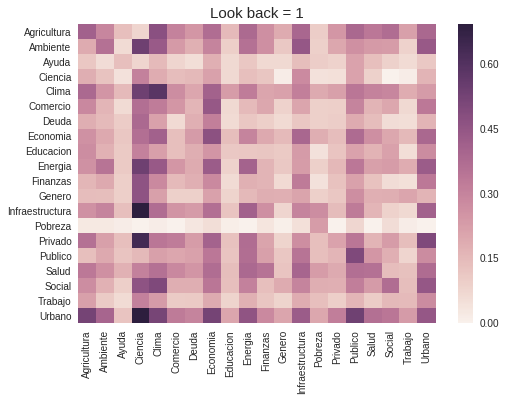

In [17]:
graficar(df_global,1)

In [ ]:
graficar_resultados(df,1)